##Pedestrian Detection

Pedestrian detection is a crucial area of computer vision with significant applications in autonomous vehicles, intelligent traffic systems, and video surveillance.  

* **Accurately identifying pedestrians in images and videos is essential for ensuring safety and enabling real-time decision-making in these domains.**

This project explores the use of Faster R-CNN50, a powerful deep learning model, for pedestrian detection. Faster R-CNN50 leverages convolutional neural networks (CNNs) to extract features from images and localize pedestrians within them.


* Why Faster R-CNN50?
Traditional pedestrian detection methods often struggle with challenges like varying pedestrian poses, occlusions, and diverse lighting conditions. Faster R-CNN50 addresses these issues through its strong learning capabilities. Here's why I've chosen it:

* High Accuracy: Faster R-CNN50 has demonstrated excellent performance in object detection tasks, achieving state-of-the-art accuracy on benchmark datasets.

* Region-based Approach: Faster R-CNN focuses on specific image regions, improving efficiency and reducing false positives compared to methods scanning entire images.

* Feature Extraction Power: The underlying CNN architecture effectively extracts discriminative features from images, allowing the model to distinguish pedestrians from background clutter.

Project Goals
This project aims to:

* Develop a robust pedestrian detection system using the Faster R-CNN50 model.
* Evaluate the model's performance on a standard pedestrian detection dataset.
* Fine-tune the model, if necessary, to improve its accuracy for specific use cases.

## Prepare Helper library
* This code downloads helper files used for an object detection project using a pre-trained model from the PyTorch vision library.

In [ ]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

## Download and Extract Dataset
* Download a dataset for pedestrian images (PennFudanPed) and then unzip it into a directory named data within the current working environment.

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2024-03-28 03:24:10--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  30.1MB/s    in 1.7s    

2024-03-28 03:24:12 (30.1 MB/s) - ‘data/PennFudanPed.zip.1’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Test and show dataset
* Reads an image and its corresponding mask from the PennFudanPed dataset, then displays them side-by-side in a figure for visualization purposes.

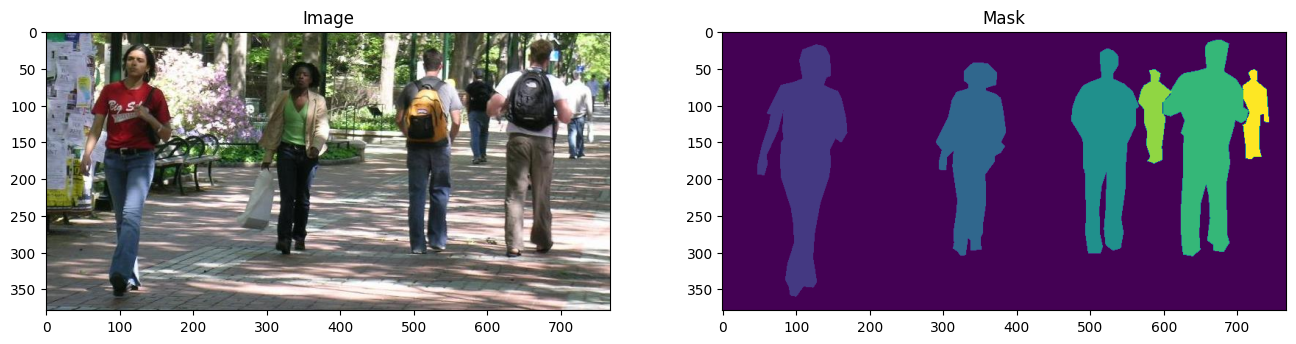

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("/content/data/PennFudanPed/PNGImages/PennPed00071.png")
mask = read_image("/content/data/PennFudanPed/PedMasks/PennPed00071_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

##Define Model
**Streamlines loading and preparing data from the PennFudanPed dataset for use in the Faster R-CNN50 object detection model.**

It handles tasks like:

* Loading images and masks.
* Converting masks to bounding boxes.
* Packaging tensors with metadata suitable for object detection.
* Facilitating optional image transformations for augmentation or preprocessing.

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Load Pretrain Model
* Takes a pre-trained Faster R-CNN model and modifies its classification head to adapt it for the specific task of pedestrian detection with two classes (person and background) using the PennFudanPed dataset.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
torch.save(model.state_dict(),"FastRCNN50.pt")

## Add preprocessing tranformation
* Define image transformations for training and data preparation. During training, it applies random horizontal flips for data augmentation and converts the image data to the appropriate format for the deep learning model.

In [ ]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Start training
* Trains the Faster R-CNN model for pedestrian detection on the PennFudanPed dataset. It defines the training configuration, prepares the data loaders, moves the model to the appropriate device, and implements an optimizer with a learning rate scheduler.
* Iterates for a specified number of epochs, performing training on batches from the training data loader, evaluating on the test set, and adjusting the learning rate throughout the process.

In [ ]:
from engine import train_one_epoch, evaluate
import utils

def train():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('/content/data/PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('/content/data/PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
train()

Epoch: [0]  [ 0/60]  eta: 0:00:45  lr: 0.000090  loss: 0.0442 (0.0442)  loss_classifier: 0.0200 (0.0200)  loss_box_reg: 0.0226 (0.0226)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.7627  data: 0.1588  max mem: 3472
Epoch: [0]  [10/60]  eta: 0:00:26  lr: 0.000936  loss: 0.0816 (0.0762)  loss_classifier: 0.0300 (0.0285)  loss_box_reg: 0.0423 (0.0428)  loss_objectness: 0.0003 (0.0017)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 0.5377  data: 0.0243  max mem: 3472
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.001783  loss: 0.0668 (0.0742)  loss_classifier: 0.0230 (0.0271)  loss_box_reg: 0.0404 (0.0430)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.5513  data: 0.0149  max mem: 3472
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.0634 (0.0785)  loss_classifier: 0.0222 (0.0279)  loss_box_reg: 0.0400 (0.0465)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0031)  time: 0.5741  data: 0.0179  max mem: 3472
Epoch: [

##Test Model
* Loads a sample image, applies necessary transformations, feeds it to the trained model, visualizes the detected pedestrians with bounding boxes and confidence scores, and displays the resulting image with predictions for visual evaluation.

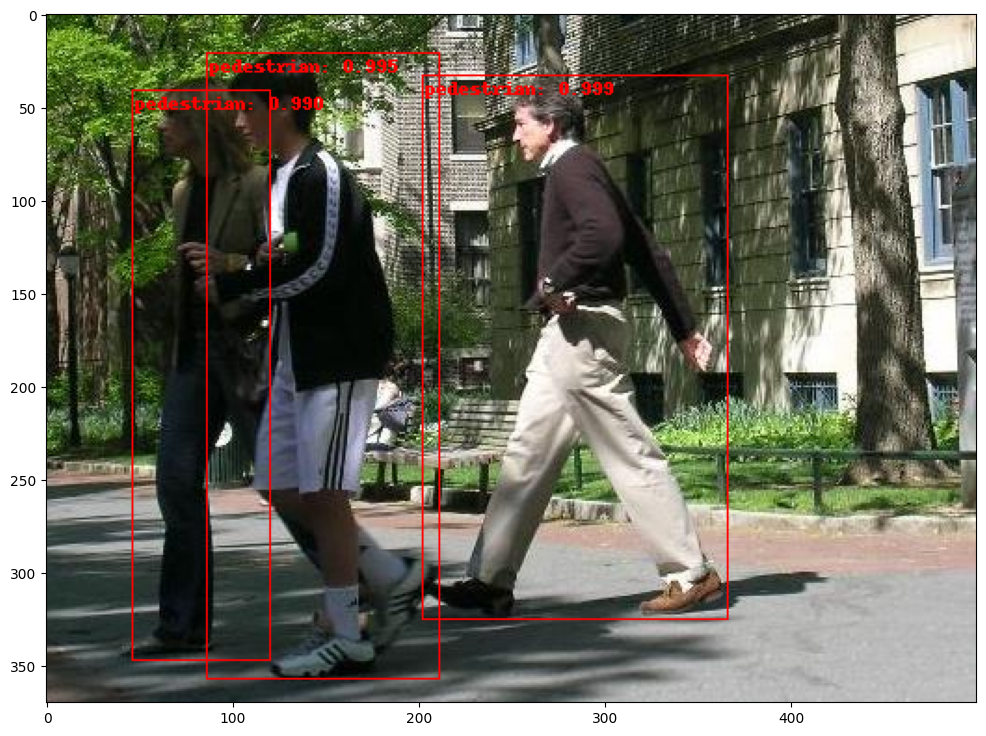

In [ ]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("data/PennFudanPed/PNGImages/PennPed00090.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

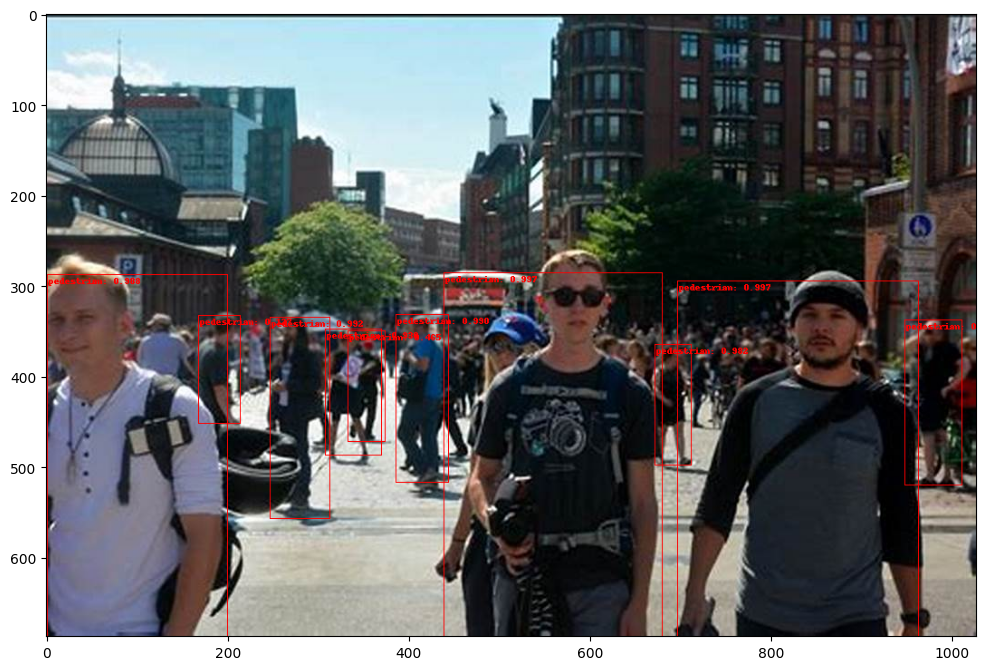

In [ ]:
#Test with Random Images
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/pedestrian.jpeg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))